In [547]:
import pathlib
import os
import json
import datetime

import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import google.generativeai as genai

from time import sleep
from google.generativeai import caching

In [544]:
CACHE_DIR = pathlib.Path(os.getcwd()) / "gemini_cache.txt"

PAYMENTS_MAIN_NEW_PATH = pathlib.Path(os.getcwd()) / ".." / "data" / "processed" / "payments_main.tsv"
PAYMENTS_MAIN_CATEGORIZED_PATH = pathlib.Path(os.getcwd()) / ".." / "data" / "processed" / "payments_categorized.tsv"

In [483]:
GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')
if GOOGLE_API_KEY is None:
    GOOGLE_API_KEY = input('Enter your Google API key: \n')
genai.configure(api_key=GOOGLE_API_KEY)

In [484]:
with open('gemini_response_schema.json' , 'r') as f:
    response_schema = json.load(f)
response_schema

{'type': 'object',
 'required': ['index', 'category'],
 'properties': {'index': {'type': 'integer'},
  'category': {'type': 'string',
   'format': 'enum',
   'enum': ['SERVICE',
    'NON_FOOD_GOODS',
    'LOAN',
    'NOT_CLASSIFIED',
    'LEASING',
    'FOOD_GOODS',
    'BANK_SERVICE',
    'TAX',
    'REAL_ESTATE']}}}

In [485]:
generation_config  = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 40,
    "max_output_tokens": 8192,
}

In [486]:
test_system_prompt = """
Ты являешься экспертом по классификации платежей. Перед тобой набор данных, где каждая строка представляет один платеж. Твоя задача - определить наиболее вероятную категорию или категории каждого платежа из следующего списка:
* **BANK_SERVICE:** Банковские услуги, комиссии банка, кредиты, платежи за счёт банка, кредиты на покупку имущества, предоставление кредита
* **FOOD_GOODS:** Продукты питания, оплата еды
* **NON_FOOD_GOODS:** Непродовольственные товары, химикаты
* **LEASING:** Лизинговые платежи
* **LOAN:** Платежи по кредитам и займам
* **REAL_ESTATE:** Операции с недвижимостью, инвестиции в недвижимость, аренда недвижимости, паевые взносы, покупка недвижимости
* **SERVICE:** Услуги (консалтинг, ремонт, транспорт и т.д.)
* **TAX:** Налоги, сборы, штрафы
* **NOT_CLASSIFIED:** Если платёж не похож на любую другую категорию или имеет с ними слишком мало общего

Данные будут представлены в виде строк, где поля разделены табуляцией. Первое поле - сумма (любой формат), второе - описание платежа.

Учти, что при выборе категории ты должен опираться на ключевые слова, относящиеся к категориям. Ключевые слова могут быть сокращены или написаны с ошибкой.

ТЫ ДОЛДЖЕН ДАТЬ КАТЕГОРИЮ КАЖДОЙ СТРОКЕ. НЕ НАРУШАЙ JSON ФОРМАТ.
"""

In [487]:
document = genai.upload_file(CACHE_DIR)

In [488]:
cache = caching.CachedContent.create(
    model='models/gemini-1.5-flash-002',
    display_name='Payment classification example',
    system_instruction=test_system_prompt,
    contents=[document],
    ttl=datetime.timedelta(hours=1),
)

In [489]:
model = genai.GenerativeModel.from_cached_content(cached_content=cache)

In [490]:
payments = pd.read_csv(PAYMENTS_MAIN_NEW_PATH, sep='\t')
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         25000 non-null  object
 1   Amount       25000 non-null  object
 2   Description  25000 non-null  object
dtypes: object(3)
memory usage: 586.1+ KB


In [491]:
chunk_size = 25

chunk_step = round(len(payments)/chunk_size)
chunk_step

1000

In [492]:
payments_chunks_raw = {str(i): {} for i in range(0, chunk_step)}
payments_chunks_processed = {str(i): {} for i in range(0, chunk_step)}

In [493]:
for i in range(len(payments_chunks_raw)):
    for j in range(chunk_size):
        row = payments.iloc[i*chunk_size + j]
        payment = row['Amount'].strip() + '\t' + row['Description'].strip()
        
        payments_chunks_raw[str(i)][str(j)] = payment

In [494]:
def contents_from_chunk(chunk):
    contents = str()
    for i in range(chunk_size):
        contents += chunk[str(i)].strip() + '\n'
    return contents.strip()

In [495]:
def validate_json(json_str):
    category_enum = [
        "SERVICE", "NON_FOOD_GOODS", "LOAN",
        "NOT_CLASSIFIED", "LEASING", "FOOD_GOODS",
        "BANK_SERVICE", "TAX", "REAL_ESTATE"
    ]
    
    try:
        data = json.loads(json_str)
        
        if not isinstance(data, list):
            return "Not a list"
        
        for item in data:
            if not isinstance(item, dict) or item['category'] not in category_enum:
                return f"Not a dictionary or index {item['index']} not in enum"
    
    except json.JSONDecodeError:
        return "Not a valid JSON string"
    
    return True

In [ ]:
while payments_chunks_processed[str(chunk_step - 1)] == {}:
    for index_chunk in payments_chunks_raw:
        if payments_chunks_processed[index_chunk] == {}:
            response = model.generate_content(contents_from_chunk(payments_chunks_raw[index_chunk]))
            response_str = response.text.strip('```json\n').replace("'", '"')
            
            validate_json_result = validate_json(response_str)
            if validate_json_result is not True:
                print(
                    f"""\n\n
                    SOMETHING WENT WRONG!!!
                    index_chunk: {index_chunk}
                    response_str: {response_str}
                    caused by: {validate_json_result}
                    \n\n"""
                )
                break
            
            response_json = json.loads(response_str)
            
            payments_chunks_processed[index_chunk] = response_json
            
            print(f"Chunk {index_chunk} completed out of {chunk_step - 1} chunks")
            sleep(1)

Chunk 690 completed out of 999 chunks
Chunk 691 completed out of 999 chunks
Chunk 692 completed out of 999 chunks
Chunk 693 completed out of 999 chunks



                    SOMETHING WENT WRONG!!!
                    index_chunk: 694
                    response_str: [{"index": 0, "category": "SERVICE"},
 {"index": 1, "category": "SERVICE"},
 {"index": 2, "category": "TAX"},
 {"index": 3, "category": "FOOD_GOODS"},
 {"index": 4, "category": "NON_FOOD_GOODS"},
 {"index": 5, "category": "REAL_ESTATE"},
 {"index": 6, "category": "SERVICE"},
 {"index": 7, "category": "SERVICE"},
 {"index": 8, "category": "LOAN"},
 {"index": 9, "category": "FOOD_GOODS"},
 {"index": 10, "category": "TAX"},
 {"index": 11, "category": "NOT_CLASSIFIED"},
 {"index": 12, "category": "LOAN"},
 {"index": 13, "category": "NON_FOOD_GOODS"},
 {"index": 14, "category": "NON_FOOD_GOODS"},
 {"index": 15, "category": "LOAN"},
 {"index": 16, "category": "FOOD_GOODS"},
 {"index": 17, "NON_FOOD_GOODS"},
 {"index": 18, "cat

In [497]:
if payments_chunks_processed[str(chunk_step - 1)] == {}:
    with open('dump_2.json', 'r') as f:
        payments_chunks_processed = json.load(f)
payments_chunks_processed

{'0': [{'index': 0, 'category': 'SERVICE'},
  {'index': 1, 'category': 'SERVICE'},
  {'index': 2, 'category': 'TAX'},
  {'index': 3, 'category': 'SERVICE'},
  {'index': 4, 'category': 'LOAN'},
  {'index': 5, 'category': 'FOOD_GOODS'},
  {'index': 6, 'category': 'BANK_SERVICE'},
  {'index': 7, 'category': 'TAX'},
  {'index': 8, 'category': 'SERVICE'},
  {'index': 9, 'category': 'LEASING'},
  {'index': 10, 'category': 'FOOD_GOODS'},
  {'index': 11, 'category': 'FOOD_GOODS'},
  {'index': 12, 'category': 'SERVICE'},
  {'index': 13, 'category': 'NOT_CLASSIFIED'},
  {'index': 14, 'category': 'FOOD_GOODS'},
  {'index': 15, 'category': 'SERVICE'},
  {'index': 16, 'category': 'NOT_CLASSIFIED'},
  {'index': 17, 'category': 'LEASING'},
  {'index': 18, 'category': 'SERVICE'},
  {'index': 19, 'category': 'NON_FOOD_GOODS'},
  {'index': 20, 'category': 'FOOD_GOODS'},
  {'index': 21, 'category': 'BANK_SERVICE'},
  {'index': 22, 'category': 'LOAN'}],
 '1': [{'index': 0, 'category': 'NON_FOOD_GOODS'},
 

In [498]:
def check_neighbours(chunks, chunk_step):
    count_identical = 0
    previous_chunk = chunks['0']
    for i in range(1, chunk_step):
        current_chunk = chunks[str(i)]
        if previous_chunk == current_chunk:
            count_identical += 1
        previous_chunk = current_chunk

In [499]:
print(check_neighbours(payments_chunks_processed, chunk_step))

None


In [525]:
payments_categorized = payments
payments_categorized['Category'] = None
payments_categorized

,Date,Amount,Description,Category
0,07.11.2024,40500.00,За тур.поездку по договору №001 от 27.01.2023г,None
1,07.11.2024,"32600,00",За оказание услуг по договору №53Б-02746 от 23...,None
2,07.11.2024,4710-00,Оплата штрафа,None
3,07.11.2024,30900-00,Лечение по договору №Д-00359/24 от 08.03.2025,None
4,07.11.2024,13200.00,Оплата основного долга за период с 16.12.2024г...,None
...,...,...,...,...
24995,07.11.2024,"3300000,00",Оплата по договору №Е01905 от 25.02.2023. сырь...,None
24996,07.11.2024,"2270,00",гос.услуга,None
24997,07.11.2024,1750000.00,Предоставление кредита по договору №Д-00803/03...,None
24998,07.11.2024,3560.00,Оплата гос. пошлины,None


In [526]:
chunk_size

25

In [527]:
chunk_step

1000

In [528]:
payments_categories = [None for _ in range(len(payments))]
len(payments_categories)

25000

In [529]:
for key, value in payments_chunks_processed.items():
    for item in value:
        if item['index'] < chunk_size:
            payments_categories[int(key)*chunk_size + item['index']] = item['category']

In [531]:
len(payments_categories) - payments_categories.count(None)

23668

In [532]:
payments_categorized['Category'] = payments_categories
payments_categorized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         25000 non-null  object
 1   Amount       25000 non-null  object
 2   Description  25000 non-null  object
 3   Category     23668 non-null  object
dtypes: object(4)
memory usage: 781.4+ KB


In [539]:
payments_categorized.dropna(inplace=True)

In [542]:
payments_categorized.reset_index(drop=True, inplace=True)

In [543]:
payments_categorized

,Date,Amount,Description,Category
0,07.11.2024,40500.00,За тур.поездку по договору №001 от 27.01.2023г,SERVICE
1,07.11.2024,"32600,00",За оказание услуг по договору №53Б-02746 от 23...,SERVICE
2,07.11.2024,4710-00,Оплата штрафа,TAX
3,07.11.2024,30900-00,Лечение по договору №Д-00359/24 от 08.03.2025,SERVICE
4,07.11.2024,13200.00,Оплата основного долга за период с 16.12.2024г...,LOAN
...,...,...,...,...
23663,07.11.2024,"3300000,00",Оплата по договору №Е01905 от 25.02.2023. сырь...,LOAN
23664,07.11.2024,"2270,00",гос.услуга,NON_FOOD_GOODS
23665,07.11.2024,1750000.00,Предоставление кредита по договору №Д-00803/03...,TAX
23666,07.11.2024,3560.00,Оплата гос. пошлины,BANK_SERVICE


In [546]:
value_counts = payments_categorized['Category'].value_counts()
value_counts

Category
SERVICE           4953
FOOD_GOODS        4787
NON_FOOD_GOODS    3564
TAX               2215
LOAN              2077
LEASING           1841
BANK_SERVICE      1536
REAL_ESTATE       1435
NOT_CLASSIFIED    1260
Name: count, dtype: int64

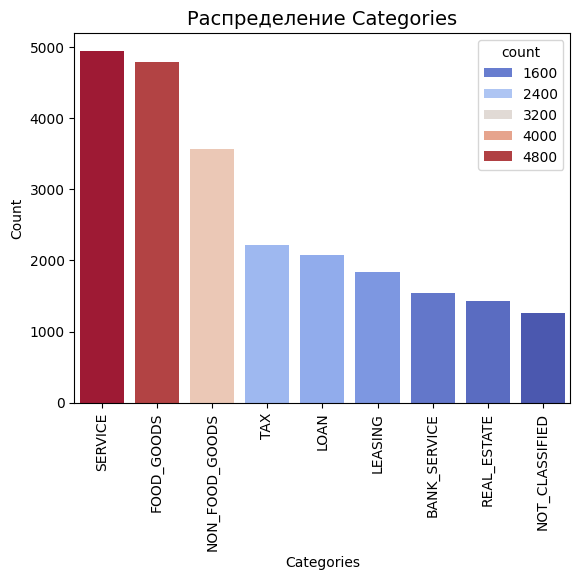

In [548]:
sns.barplot(
    x=value_counts.index,
    y=value_counts,
    palette='coolwarm',
    hue=value_counts
)
plt.xlabel('Categories', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Распределение Categories', fontsize=14)
plt.xticks(rotation=90)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.show()

In [545]:
payments_categorized.to_csv(PAYMENTS_MAIN_CATEGORIZED_PATH, sep='\t', index=False)